In [1]:
require(ecipex)
require(tidyverse)
require(stringr)
require(broom)
require(readxl)

setwd('~/stanford/experiments/exp_218')

Loading required package: ecipex
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.4.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: broom
Loading required package: readxl


# Overview

This notebook shows how to turn mass isotopologue distribution data for a metabolite into a single number describing the heavy label content of the metabolite in _two_ different ways.  

1. No assumptions: calculate total D content by mass balance.  (Really, there is one assumption: you know the structure of your metabolite and how many solvent-exchangeable hydrogens it has, but that's it.)

2. Single-degree-of-freedom model.  Assume that all (non-exchangeable) hydrogens in your metabolite have the same, unknown probability of being labeled.  Estimate the single labeling probability from the data.


The data shown here was generated by Tim S. and Curt F. in 2019, and thus this notebook uses pheophytin A.

## First approach
First, using no assumptions, the "neutron excess" or NE is calculated from an MID.  This doesn't depend on any assumptions about the distribution of these excess neutrons in a molecule.  It is just calculated from

$$\mathrm{NE}=\frac{\sum_{i=0}^n i\;M_i}{n}$$

where $n$ is the number of (integer) mass isotopologues that a moleclue has, and $M_i$ the relative abundance of the $i$th isotopologue.  Some examples:  
1. If a molecule with 12 label-able positions (i.e. $n$ = 12) were completely labeled, it would have zero abundance for $M_0$, $M_1$, $M_3$, ..., $M_{11}$, and abundance 1 for $M_{12}$, so the neutron excess would be $\frac{12 * 1}{12}=1$.
2. If a molecule with 12 label-able positions had no intensity for $M_0$, $M_1$, $M_3$, ..., $M_{10}$, had an intensity 1 for $M_{11}$, and no intensity at all for $M_{12}$, the neutron excess would be $\frac{11 * 1}{12}\approx 0.91$
3. If a molecule with 12 label-able positions had equal intensities for all peaks, i.e. $M_0=M_1=...=M_{12}=\frac{1}{13}$, then the neutron excess would be 0.5.  This would also be the neutron abundance for an MID with $M_0=M_{12}=0.5$ and $M_1=M_2=...=M_{11}=0$.

We can correct the neutron abundance for the predicted natural abundance of neutrons in an MID.  Here this corrected value is the "differential neutron excess" or $\Delta \mathrm{NE}=\mathrm{NE} - \mathrm{NE}_{natural}$  These natural abundance estimates aren't perfect because there isn't really a single value for "natural", and much more importantly, mass spectrometers imprecisely measure MIDs because of truncation effects.  Weak peaks will be systematically weakened, and strong peaks systematically strengthened, because of signal-to-noise issues and signal processing artifacts.  

## pheophytin A definitions

In [2]:
PHEO_A <- 'C55H74N4O5'

## load data

In [45]:
my_mid_files <- list.files('mid_files/2019-09-03/', '*.csv', full.names = T)

all_data <- 
    map(my_mid_files, read_csv) %>% 
    bind_rows() %>%
    mutate(sample = str_extract(mzml_file, '(?<=mzml_files/).*(?=[.]mzML)')) %>%
    mutate(ion = paste0('M', m)) %>%
    select(-X1) %>%
    mutate(sample_group = str_extract(sample, '[A-Z0-9]{2}(?=[0-9]{1}$)')) %>%
    mutate(sample = str_extract(mzml_file, '(?<=full_experiment[/]).*(?=[.]mzML)'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format =

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_i

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_i

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_i

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_i

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_i

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_integer(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_double(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_

“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_integer(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col_integer(),
  mean_mz = col_integer(),
  mid = col_double(),
  mzml_file = col_character(),
  raw_intensity = col_double(),
  structure = col_character()
)
Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_integer(),
  C13_theo_mz = col_double(),
  N15_theo_mz = col_double(),
  analysis_date = col_datetime(format = ""),
  m = col

In [46]:
all_data %>% 
    head

C13_theo_mz,N15_theo_mz,analysis_date,m,mean_mz,mid,mzml_file,raw_intensity,structure,sample,ion,sample_group
871.5732,871.5732,2019-09-03 16:53:57,0,871.5748,0.5348103525,mzml_files/2019-09-03_full_experiment/A11.mzML,61393597.65,pheophytin_a_ion.sdf,A11,M0,A1
872.5766,872.5702,2019-09-03 16:53:57,1,872.5778,0.3371571252,mzml_files/2019-09-03_full_experiment/A11.mzML,38703979.44,pheophytin_a_ion.sdf,A11,M1,A1
873.5799,873.5673,2019-09-03 16:53:57,2,873.5809,0.1030780373,mzml_files/2019-09-03_full_experiment/A11.mzML,11832851.63,pheophytin_a_ion.sdf,A11,M2,A1
874.5833,874.5643,2019-09-03 16:53:57,3,874.5841,0.0215527154,mzml_files/2019-09-03_full_experiment/A11.mzML,2474145.71,pheophytin_a_ion.sdf,A11,M3,A1
875.5866,875.5613,2019-09-03 16:53:57,4,875.5861,0.0028892440,mzml_files/2019-09-03_full_experiment/A11.mzML,331671.00,pheophytin_a_ion.sdf,A11,M4,A1
876.5900,876.5584,2019-09-03 16:53:57,5,876.5866,0.0003941328,mzml_files/2019-09-03_full_experiment/A11.mzML,45244.51,pheophytin_a_ion.sdf,A11,M5,A1


Adding missing grouping variables: `sample_group`


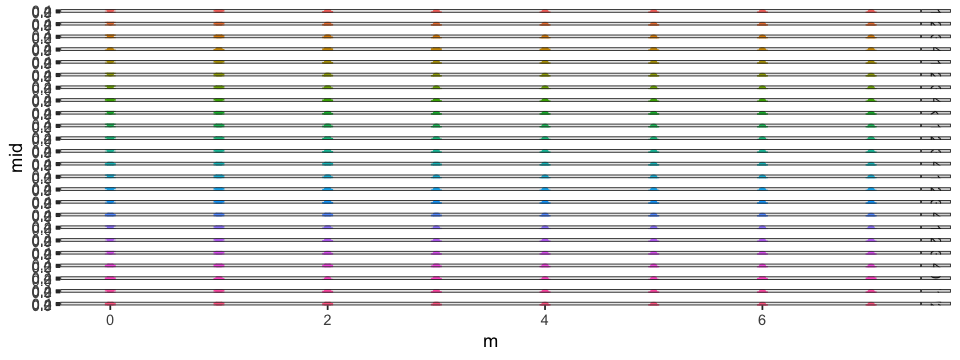

In [47]:
all_data %>% 
    group_by(sample_group) %>%
    filter(sample == first(sample)) %>%
    select(sample, m, mid) %>% 
    ggplot(aes(x=m, y=mid, color=sample, ymin=0, ymax=mid)) +
        geom_point(position = position_dodge(width=0.2)) +
        geom_errorbar(width=0.1, position=position_dodge(width=0.2)) +
        facet_grid(sample ~ .) +
        theme_bw() +
        theme(legend.position = 'none')

#### calc MIDs

In [48]:
my_formulae <- list(PHEO_A)

mids <- ecipex(my_formulae, isoinfo = nistiso, id = T, limit=1e-6)

for(df_name in names(mids)){
    mids[[df_name]]$formula <- df_name
}

all_mids <- bind_rows(mids)

In [49]:
all_mid_annot <- all_mids %>% 
    mutate(int_mass = round(mass, 0)) %>%
    group_by(formula, int_mass) %>%
    summarize(total_abund = sum(abundance), mass = sum(mass*abundance)/sum(abundance)) %>%
    group_by(int_mass) %>%
    arrange(int_mass) 

In [50]:
with.theoretical <- all_mid_annot %>%
    ungroup %>%
    mutate(ion = paste0('M', (int_mass-min(int_mass))), sep='') %>%
    mutate(theoretical_mid = total_abund / sum(total_abund)) %>%
    select(ion, theoretical_mid) %>%
    left_join(all_data, by=c('ion')) %>%
    rename(experimental_mid = mid) %>%
    group_by(sample) %>%
    mutate(diff = experimental_mid - theoretical_mid)

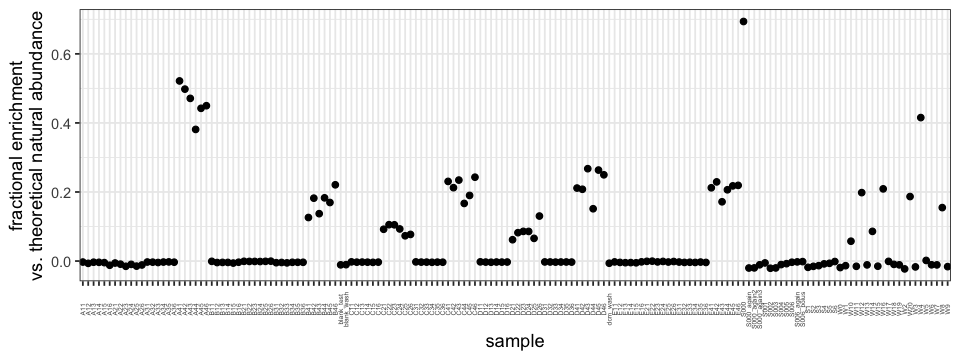

In [52]:
options(repr.plot.width = 8, repr.plot.height=3)
with.theoretical %>%
    select(sample, ion, diff) %>%
    spread(ion, diff) %>%
    mutate(neutron_excess = (0*M0 + 1*M1 + 2*M2 + 3*M3 + 4*M4 + 5*M5 + 6*M6 + 7*M7)/4) %>%  #4 is number of N in pheoA
    ggplot(aes(x=sample,
               y = neutron_excess, 
               )
           ) +
        geom_point() +
        theme_bw() +
        ylab('fractional enrichment\nvs. theoretical natural abundance') +
        xlab('sample') +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, size=4))

ggsave('graphs/2019-09-03/tim_15N_content_by_sample.pdf', h=3, w=8)

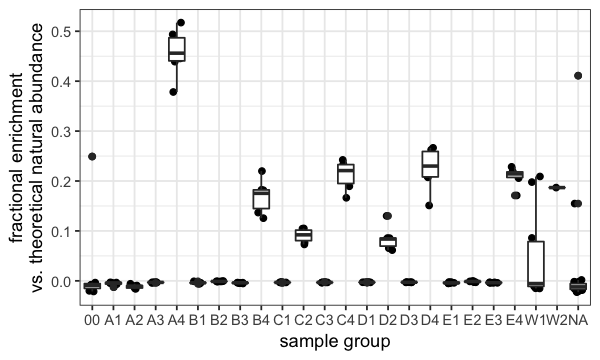

In [54]:
options(repr.plot.width = 5, repr.plot.height=3)
with.theoretical %>%
    select(sample, ion, diff) %>%
    distinct %>%
    spread(ion, diff) %>%
    mutate(neutron_excess = (0*M0 + 1*M1 + 2*M2 + 3*M3 + 4*M4 + 5*M5 + 6*M6)/4) %>%  #4 is number of N in pheoA
    mutate(sample_group = str_extract(sample, '[A-Z0-9]{2}(?=[0-9]{1}$)')) %>%
    ggplot(aes(x = sample_group,
               y = neutron_excess, 
               )
           ) +
        geom_jitter(width=0.2) +
        geom_boxplot() +
        theme_bw() +
        ylab('fractional enrichment\nvs. theoretical natural abundance') +
        xlab('sample group')

ggsave('graphs/2019-09-03/tim_15N_content_by_type.pdf', h=3, w=8)

## Second approach
Second, we assume that all nitrogens in a molecule are equally likely to be labeled with an unknown probability, and use fitting routines to estimate the probability.  This is a "single-degree of freedom" model. 

In [55]:
predict_mid <- function(formula, abund, m_keeps=NULL){
    # configure isotope info
    my_iso <- nistiso
    
    # assume N is the isotopically labeled element; use Ir to represent label-able Hs
    my_iso[my_iso$element == 'N', 'abundance'] <- c(1-abund, abund)
    
    # find default m_keeps
    if(is.null(m_keeps)){
        range <- ecipex(formula, isoinfo=my_iso)[[1]]$mass %>% round(0)
        m_keeps <- (range - min(range)) %>% unique
    }
    
    # get MID
    res1 <- ecipex(formula, 
                  isoinfo=my_iso,                 
                  sortby='abund'
                 )[[1]] %>%
           mutate(int_mass = round(mass, 0)) %>%
           mutate(m = int_mass - min(int_mass)) %>%
           group_by(m) %>%
           summarize(abundance = sum(abundance))
    res2 <- res1 %>%
           filter(m %in% m_keeps) %>% 
           mutate(abundance = abundance/sum(abundance)) %>%  # renormalize
           pull(abundance)
    return(res2)
}

In [56]:
mid.data.prepped <- 
    all_data %>% 
        group_by(sample) %>%
        mutate(m = str_extract(ion, '(?<=M)[0-9]*$') %>% as.numeric) %>%
        filter(m %in% 0:6)

fit <- mid.data.prepped %>%
        do(augment(nls(data=.,
            formula=mid ~ predict_mid(PHEO_A, abund, m_keeps = 0:6),
            start = list(abund=0.1),
            lower = c(0),
            upper = c(1),
            algorithm="port",
            control=nls.control(warnOnly=T)
                   )
               )
          )

Warning message:
“`env_bind_fns()` is deprecated as of rlang 0.3.0.
Please use `env_bind_active()` instead.
This warning is displayed once per session.”Warning message:
“`overscope_clean()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

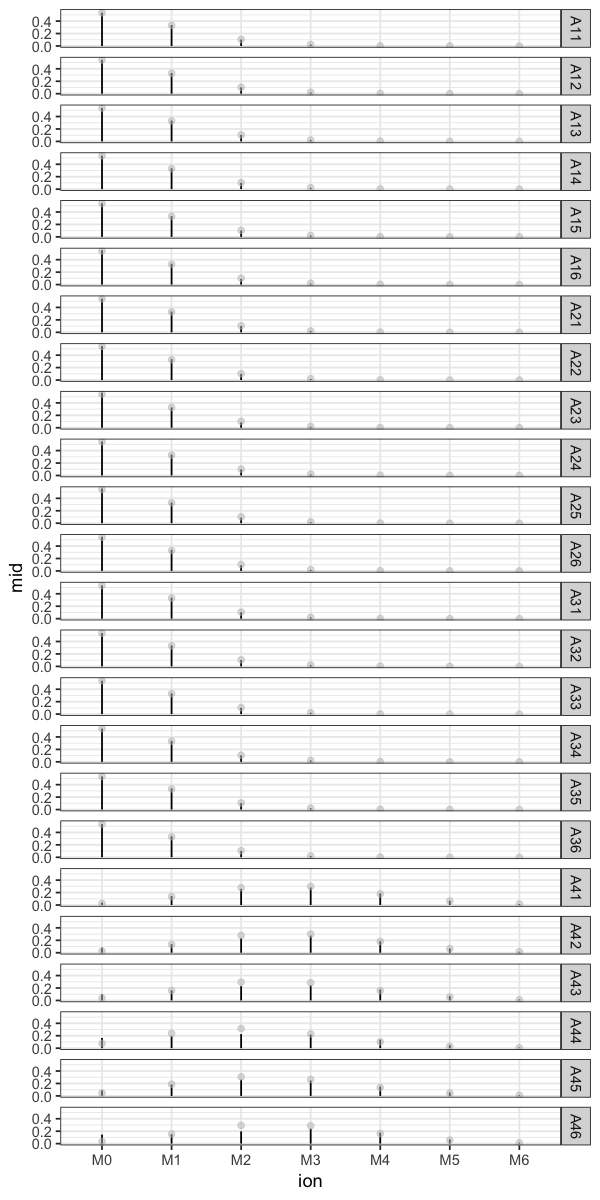

In [59]:
options(repr.plot.width=5, repr.plot.height=10)
fit %>% 
    left_join(mid.data.prepped, by=c('sample', 'mid')) %>%
    ungroup %>%
    filter(sample_group %in% c('A1', 'A2', 'A3', 'A4')) %>%
    select(sample, ion, mid, .fitted) %>%
    ggplot(aes(x=ion, y=mid, ymin=0, ymax=mid)) +
        geom_errorbar(width=0) +
        geom_point(color='gray', aes(x=ion, y=.fitted), alpha=0.5) +
        facet_grid(sample ~ .) +
        theme_bw() 

ggsave('graphs/2019-09-03/best_fit_mids_vs_measured_mids_for_A_samples.pdf', h=5, w=5)

In [60]:
fit_results <- mid.data.prepped %>%
        do(tidy(nls(data=.,
            formula=mid ~ predict_mid(PHEO_A, abund, m_keeps = 0:6),
            start = list(abund=0.1),
            lower = c(0),
            upper = c(1),
            algorithm="port",
            control=nls.control(warnOnly=T)
                   )
               )
          )

In [61]:
fit_results

sample,term,estimate,std.error,statistic,p.value
A11,abund,0.0036328730,0.0011884326,3.0568609,2.231464e-02
A12,abund,0.0000000000,0.0009628492,0.0000000,1.000000e+00
A13,abund,0.0026132909,0.0009952922,2.6256520,3.928766e-02
A14,abund,0.0023171653,0.0009816883,2.3603880,5.625425e-02
A15,abund,0.0015817455,0.0009470607,1.6701629,1.459246e-01
A16,abund,0.0000000000,0.0029154996,0.0000000,1.000000e+00
A21,abund,0.0008792112,0.0010524839,0.8353678,4.355062e-01
A22,abund,0.0000000000,0.0018468726,0.0000000,1.000000e+00
A23,abund,0.0000000000,0.0045005905,0.0000000,1.000000e+00
A24,abund,0.0000000000,0.0020093939,0.0000000,1.000000e+00


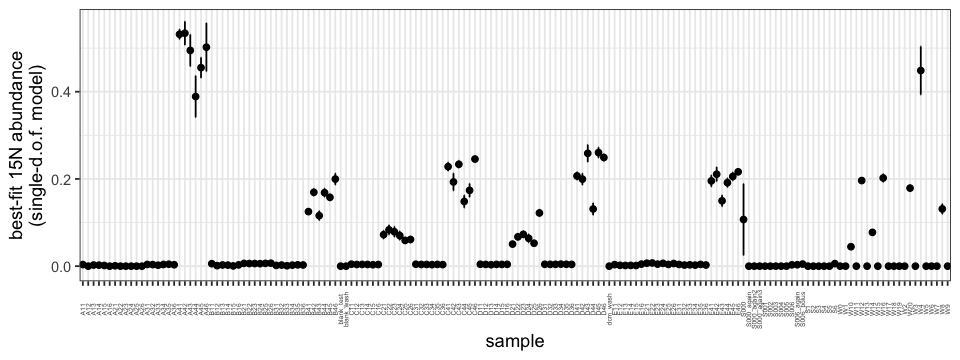

In [62]:
options(repr.plot.width = 8, repr.plot.height=3)
fit_results %>%
    ggplot(aes(x=sample, 
               y=estimate, 
               ymin=estimate - std.error,
               ymax=estimate + std.error,
               )
           ) +
        geom_point() + 
        geom_errorbar(width=0.1) +
        xlab('sample') +
        ylab('best-fit 15N abundance\n(single-d.o.f. model)') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, size=4))

ggsave('graphs/2019-09-03/tim_15N_content_by_sample_best_fit.pdf', h=3, w=8)

## Comparing the two approaches

In [63]:
second_approach <- fit_results

first_approach <- 
    with.theoretical %>%
    select(sample, ion, diff) %>%
    spread(ion, diff) %>%
    mutate(neutron_excess = (0*M0 + 1*M1 + 2*M2 + 3*M3 + 4*M4 + 5*M5 + 6*M6)/4) 

Joining, by = "sample"


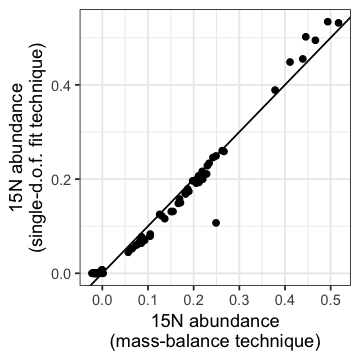

In [64]:
options(repr.plot.width=3, repr.plot.height=3)
first_approach %>% select(sample, abund1 = neutron_excess) %>%
    left_join(second_approach %>% select(sample, abund2=estimate)) %>%
    ggplot(aes(x=abund1, y=abund2)) +
        geom_point() +
        theme_bw() +
        geom_abline(slope=1) +
        xlab('15N abundance\n(mass-balance technique)') +
        ylab('15N abundance\n(single-d.o.f. fit technique)')

ggsave('graphs/2019-09-03/comparing_two_methods_for_estimating_enrichment.pdf', h=3, w=3)

In [67]:
first_approach %>% select(sample, abund1 = neutron_excess) %>%
    left_join(second_approach %>% select(sample, abund2=estimate)) %>%
    ungroup %>%
    filter((abund1 - abund2)**2 == max(abund1 - abund2)**2)

Joining, by = "sample"


sample,abund1,abund2
S000,0.2490241,0.1070087


## A third approach: m/z values

The qTOF we have has insufficent resolution to resolve 13C isotopomers from 15N isotopomers, but as a result the measured $m/z$ of an isotopic peak is determined by the relative amounts of these isotopomers.  This again determined by the atomic fractional abundance of 15N and 13C.  For example, a molecule that no heavy isotopes except 13C would have each isotopomer separated in mass by 1.0034 Da.  A molecule that had no heavy isotopes except 15N would have each isotopomer separated by 0.997 Da.  Molecules that had some of both would have measured integer isotopologue $m/z$ values that differ from the monoisotopic by an intermediate value.  The intermediate value is determined by the relative numbers of atoms of C and N in the molecule, and the relative abundances of heavy C and heavy N isotopes.

We can use the R package ecipex to fit abundances to the measured $m/z$ values, a third independent measurement of isotopic content.  We again assume the "single-degree-of-freedom", i.e. that all atoms of a certain element in a molecule have the same probability of being labeled (or not).

In [68]:
C13_NEUTRON = 13.0033548378 - 12
N15_NEUTRON = 15.0001088990 - 14.00307400446

In [69]:
predict_mzs <- function(formula, abund, abund2, m_keeps=NULL){
    # configure isotope info
    my_iso <- nistiso
    
    # assume N is the isotopically labeled element
    my_iso[my_iso$element == 'N', 'abundance'] <- c(1-abund, abund)
    
    # find default m_keeps
    if(is.null(m_keeps)){
        range <- ecipex(formula, isoinfo=my_iso)[[1]]$mass %>% round(0)
        m_keeps <- (range - min(range)) %>% unique
    }
    
    # get MID
    res1 <- ecipex(formula, 
                  isoinfo=my_iso,                 
                  sortby='abund',
                  limit = 1e-6,
                 )[[1]] %>%
           mutate(int_mass = round(mass, 0)) %>%
           mutate(m = int_mass - min(int_mass)) %>%
           group_by(m) %>%
           summarize(mean_mass = sum(abundance * mass) / sum(abundance))
    res2 <- res1 %>%
           filter(m %in% m_keeps) %>% 
           pull(mean_mass) + 1.00727647
    return(res2)
}

The results of this third fitting requires some care.  Because the fitting depends in a large degree on the last two decimal places of the measured $m/z$, it may be the least precise.  

The parameter `eps` is included below in an attempt to account for mass inaccuracy.  Mass inaccuracy in the instrument usually manifests as a *shift* in all $m/z$ values in a spectrum.  For example, the mass of M0 we measure for pheophytin A is 1.4 to 3.7 ppm *higher* than the theoretical.  This is well within the specs of our instrument, but if the M1, M2, etc. masses are similarly higher than the true values, the fit will underestimate the abundance of 15N, since 15N is lighter than carbon-13.  To avoid this bias caused from instrument mass error, we introduce the `eps` parameter, which lets the $m/z$ values of all peaks in an isotopic envelope float by the same amount.  We introduce this parameter on a sample-specific basis becaue it is easiest; future efforts might improve this assumption -- a global `eps` parameter that is the same for all samples might be preferable but more complex to implement.

In [70]:
my_m <- 0:5

fit_mz_results <- mid.data.prepped %>%
        filter(m %in% my_m) %>%
        #filter(sample != 'P1-E1') %>%
        do(tidy(nls(data=.,
            formula=mean_mz ~ predict_mzs(PHEO_A, abund, m_keeps = my_m) + 0*m + eps,
            start = list(abund=0.05, eps=0),
            lower = c(0, -0.005),
            upper = c(1, 0.005),
            algorithm="port",
            control=nls.control(warnOnly=T),
            
                   )
               )
          )

Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false conve

“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, a

“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: false convergence (8)”Warning message in nls(data = ., formula = mean_mz ~ predict_mzs(PHEO_A, abund, :
“Convergence failure: singular convergence (7)”Warning message in nls(data = ., formula = mean_mz ~ 

In [71]:
third_approach <- 
    fit_mz_results %>%
    filter(term == 'abund')

In [72]:
all_data %>%
    filter(m == 0) %>%
    mutate(ppm = (mean_mz - C13_theo_mz)/C13_theo_mz*1e6,
           diff = mean_mz - C13_theo_mz) %>%
    select(sample, mean_mz, theo_mz = C13_theo_mz, ppm, diff)

sample,mean_mz,theo_mz,ppm,diff
A11,871.5748,871.5732,1.824579e+00,1.590254e-03
A12,871.5746,871.5732,1.651135e+00,1.439085e-03
A13,871.5751,871.5732,2.125073e+00,1.852157e-03
A14,871.5751,871.5732,2.238136e+00,1.950699e-03
A15,871.5746,871.5732,1.652838e+00,1.440570e-03
A16,871.5745,871.5732,1.506766e+00,1.313256e-03
A21,0.0000,871.5732,-1.000000e+06,-8.715732e+02
A22,871.5741,871.5732,1.077038e+00,9.387174e-04
A23,871.5739,871.5732,7.895117e-01,6.881172e-04
A24,871.5746,871.5732,1.594226e+00,1.389484e-03


Joining, by = "sample"


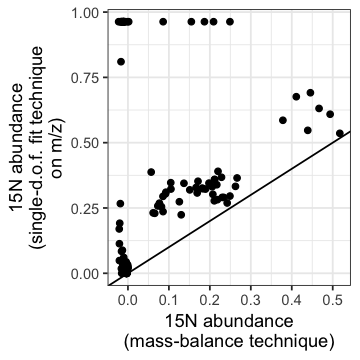

In [74]:
#options(repr.plot.width=4, repr.plot.height=3)
first_approach %>% select(sample, abund1 = neutron_excess) %>%
    left_join(third_approach %>% select(sample, abund2=estimate)) %>%
    ggplot(aes(x=abund1, y=abund2)) +
        geom_point() +
        theme_bw() +
        geom_abline(slope=1) +
        xlab('15N abundance\n(mass-balance technique)') +
        ylab('15N abundance\n(single-d.o.f. fit technique\non m/z)') 

#ggsave('graphs/comparing_a_third_for_estimating_enrichment.pdf', h=3, w=4)

In [76]:
# first method
with.theoretical %>%
    select(sample, ion, diff) %>%
    spread(ion, diff) %>%
    mutate(neutron_excess = (0*M0 + 1*M1 + 2*M2 + 3*M3 + 4*M4 + 5*M5 + 6*M6)/4)#4 is number of N in pheoA



# # second method
# fit_results %>%
#     filter(str_detect(sample, 'A'), term=='abund')

# # third method
# fit_mz_results %>%
#     filter(str_detect(sample, 'A'), term=='abund')


sample,M0,M1,M2,M3,M4,M5,M6,M7,neutron_excess
A11,5.757036e-04,0.005988349,-0.003321855,-0.001993985,-0.0011309063,-1.660921e-04,5.404969e-07,4.824518e-05,-0.0029970398
A12,8.760854e-03,0.001637659,-0.004537987,-0.004224735,-0.0015444289,-1.624539e-04,-6.671167e-06,7.776258e-05,-0.0067856326
A13,2.611379e-03,0.004121022,-0.004094755,-0.001318423,-0.0011499281,-2.042201e-04,-4.810908e-07,3.540648e-05,-0.0034118642
A14,3.283864e-03,0.003836089,-0.004185885,-0.001598227,-0.0012219601,-1.830619e-04,8.390601e-06,6.079001e-05,-0.0037707916
A15,4.965972e-03,0.003106329,-0.004412590,-0.002190090,-0.0013370557,-2.089733e-04,1.268124e-05,6.372690e-05,-0.0046515308
A16,1.789722e-02,0.004645976,-0.014854926,-0.006476295,-0.0015242220,1.827820e-05,4.910787e-06,2.890557e-04,-0.0126171980
A21,6.652025e-03,0.003060608,-0.004903150,-0.003210667,-0.0014056073,-1.868954e-04,-6.490392e-05,5.859019e-05,-0.0058310056
A22,1.138281e-02,0.004844854,-0.008539200,-0.006242446,-0.0016018667,-1.467993e-04,1.024809e-04,2.001696e-04,-0.0093718658
A23,2.965401e-02,-0.003419996,-0.019585609,-0.006671902,-0.0007400141,1.679687e-04,1.174264e-04,4.781184e-04,-0.0160056435
A24,1.277448e-02,0.004654920,-0.009722380,-0.006387306,-0.0014806422,-2.488181e-04,1.388541e-04,2.708935e-04,-0.0100713228
